In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv('Datasets/drugsComTrain_raw.csv')
df_test = pd.read_csv('Datasets/drugsComTest_raw.csv')

print("Train shape :" ,df_train.shape)
print("Test shape :", df_test.shape)

Train shape : (161297, 7)
Test shape : (53766, 7)


In [3]:
df = pd.concat([df_train,df_test]).reset_index()
del df['index']
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     215063 non-null  int64 
 1   drugName     215063 non-null  object
 2   condition    213869 non-null  object
 3   review       215063 non-null  object
 4   rating       215063 non-null  int64 
 5   date         215063 non-null  object
 6   usefulCount  215063 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 11.5+ MB


In [5]:
print("unique values of ID: " , len(set(df['uniqueID'].values)))
print("length of data: " , df.shape[0])

unique values of ID:  215063
length of data:  215063


#### We compared the unique number of unique IDs and the length of the train data to see if the same patient has written multiple reviews or not? There weren't more than one review per patient.

Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

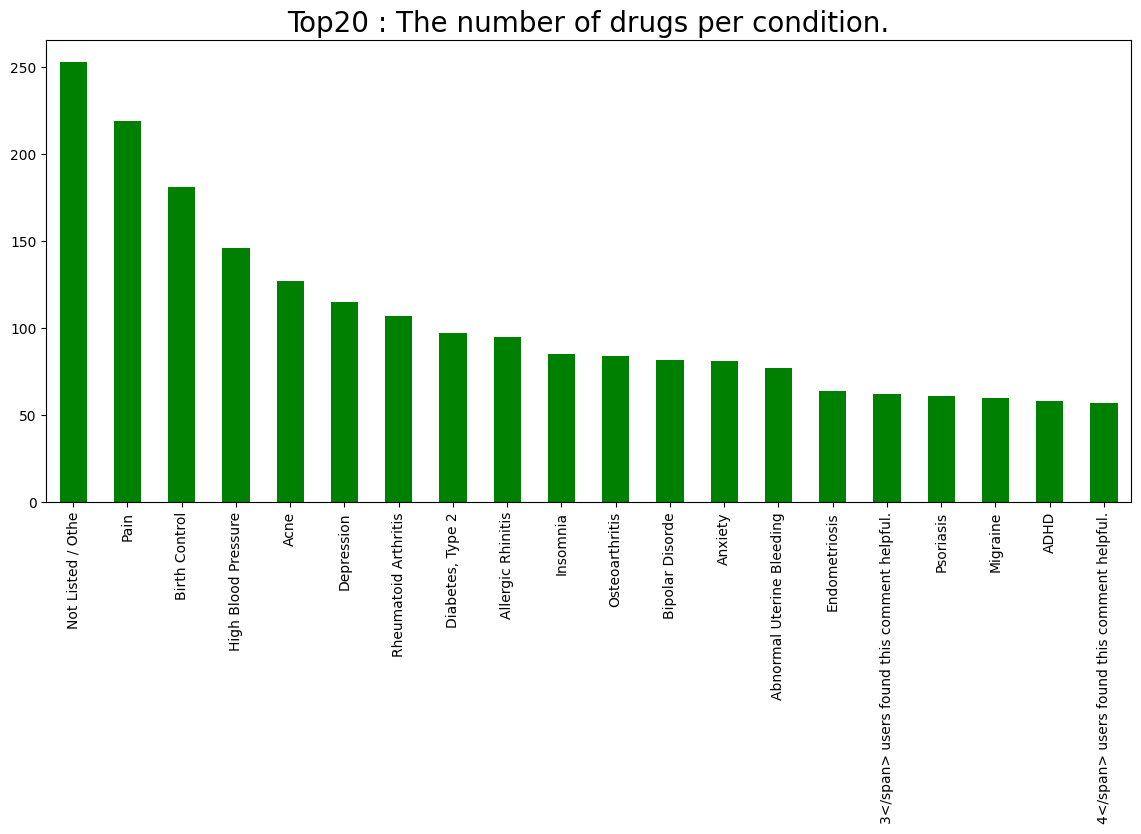

In [6]:
condition_dn = df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

Text(0.5, 1.0, 'Bottom20 : The number of drugs per condition.')

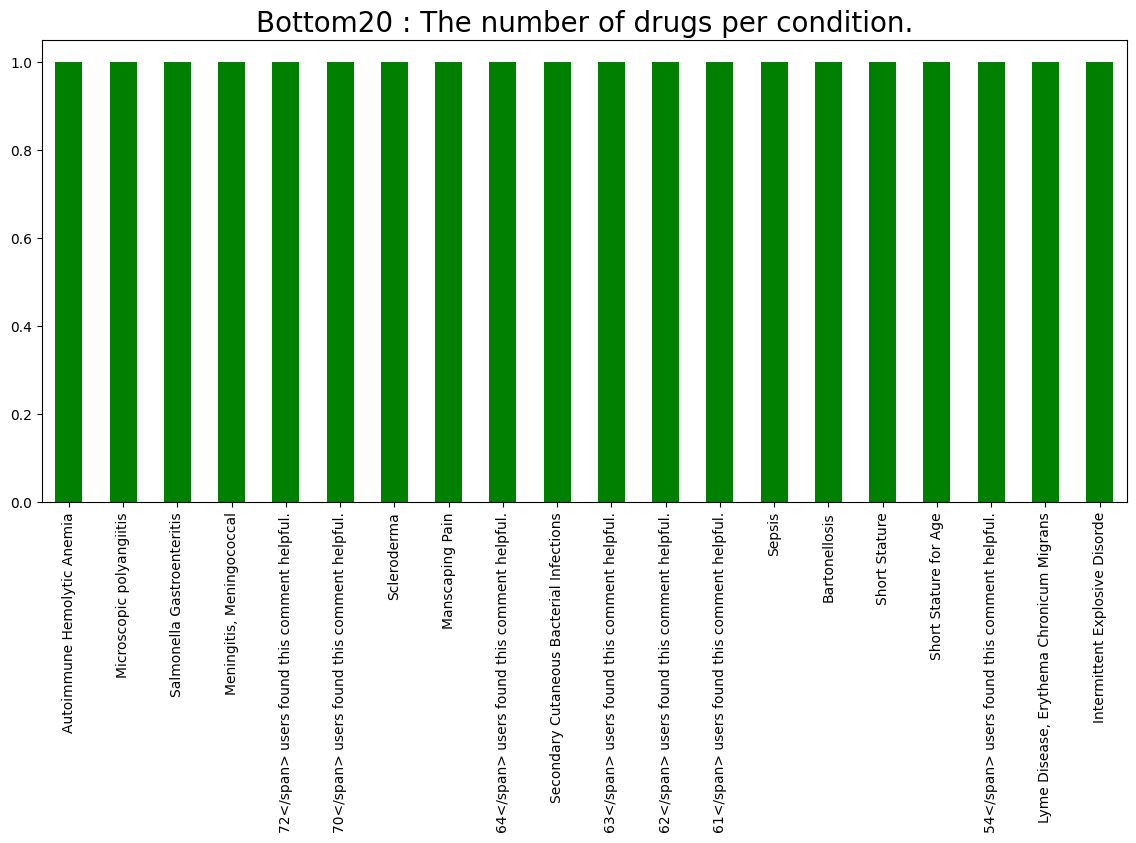

In [7]:
condition_dn = df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)

condition_dn[condition_dn.shape[0]-20:condition_dn.shape[0]].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Bottom20 : The number of drugs per condition.", fontsize = 20)

#### We checked the number of 'drugs per condition'. Considering the recommendation system, it is not feasible to recommend when there is only one product. Therefore, we will analyze only the conditions that have at least 2 drugs per condition.
#### We also checked the name of conditions and some of them contain the phrase "\</span> users found this comment helpful", which seems like an error in the crawling process.

In [8]:
df_train['review'][1]

'"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."'

In [9]:
df_train['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

#### In reviews, there were some words with errors like didn\&#039;t for didn't, and also html strings like \ r \ n, and the parts that express emotions in parentheses such as (very unusual for him) and (a good thing) are words in capital letters like MUCH. We will delete these parts in preprocessing as well.

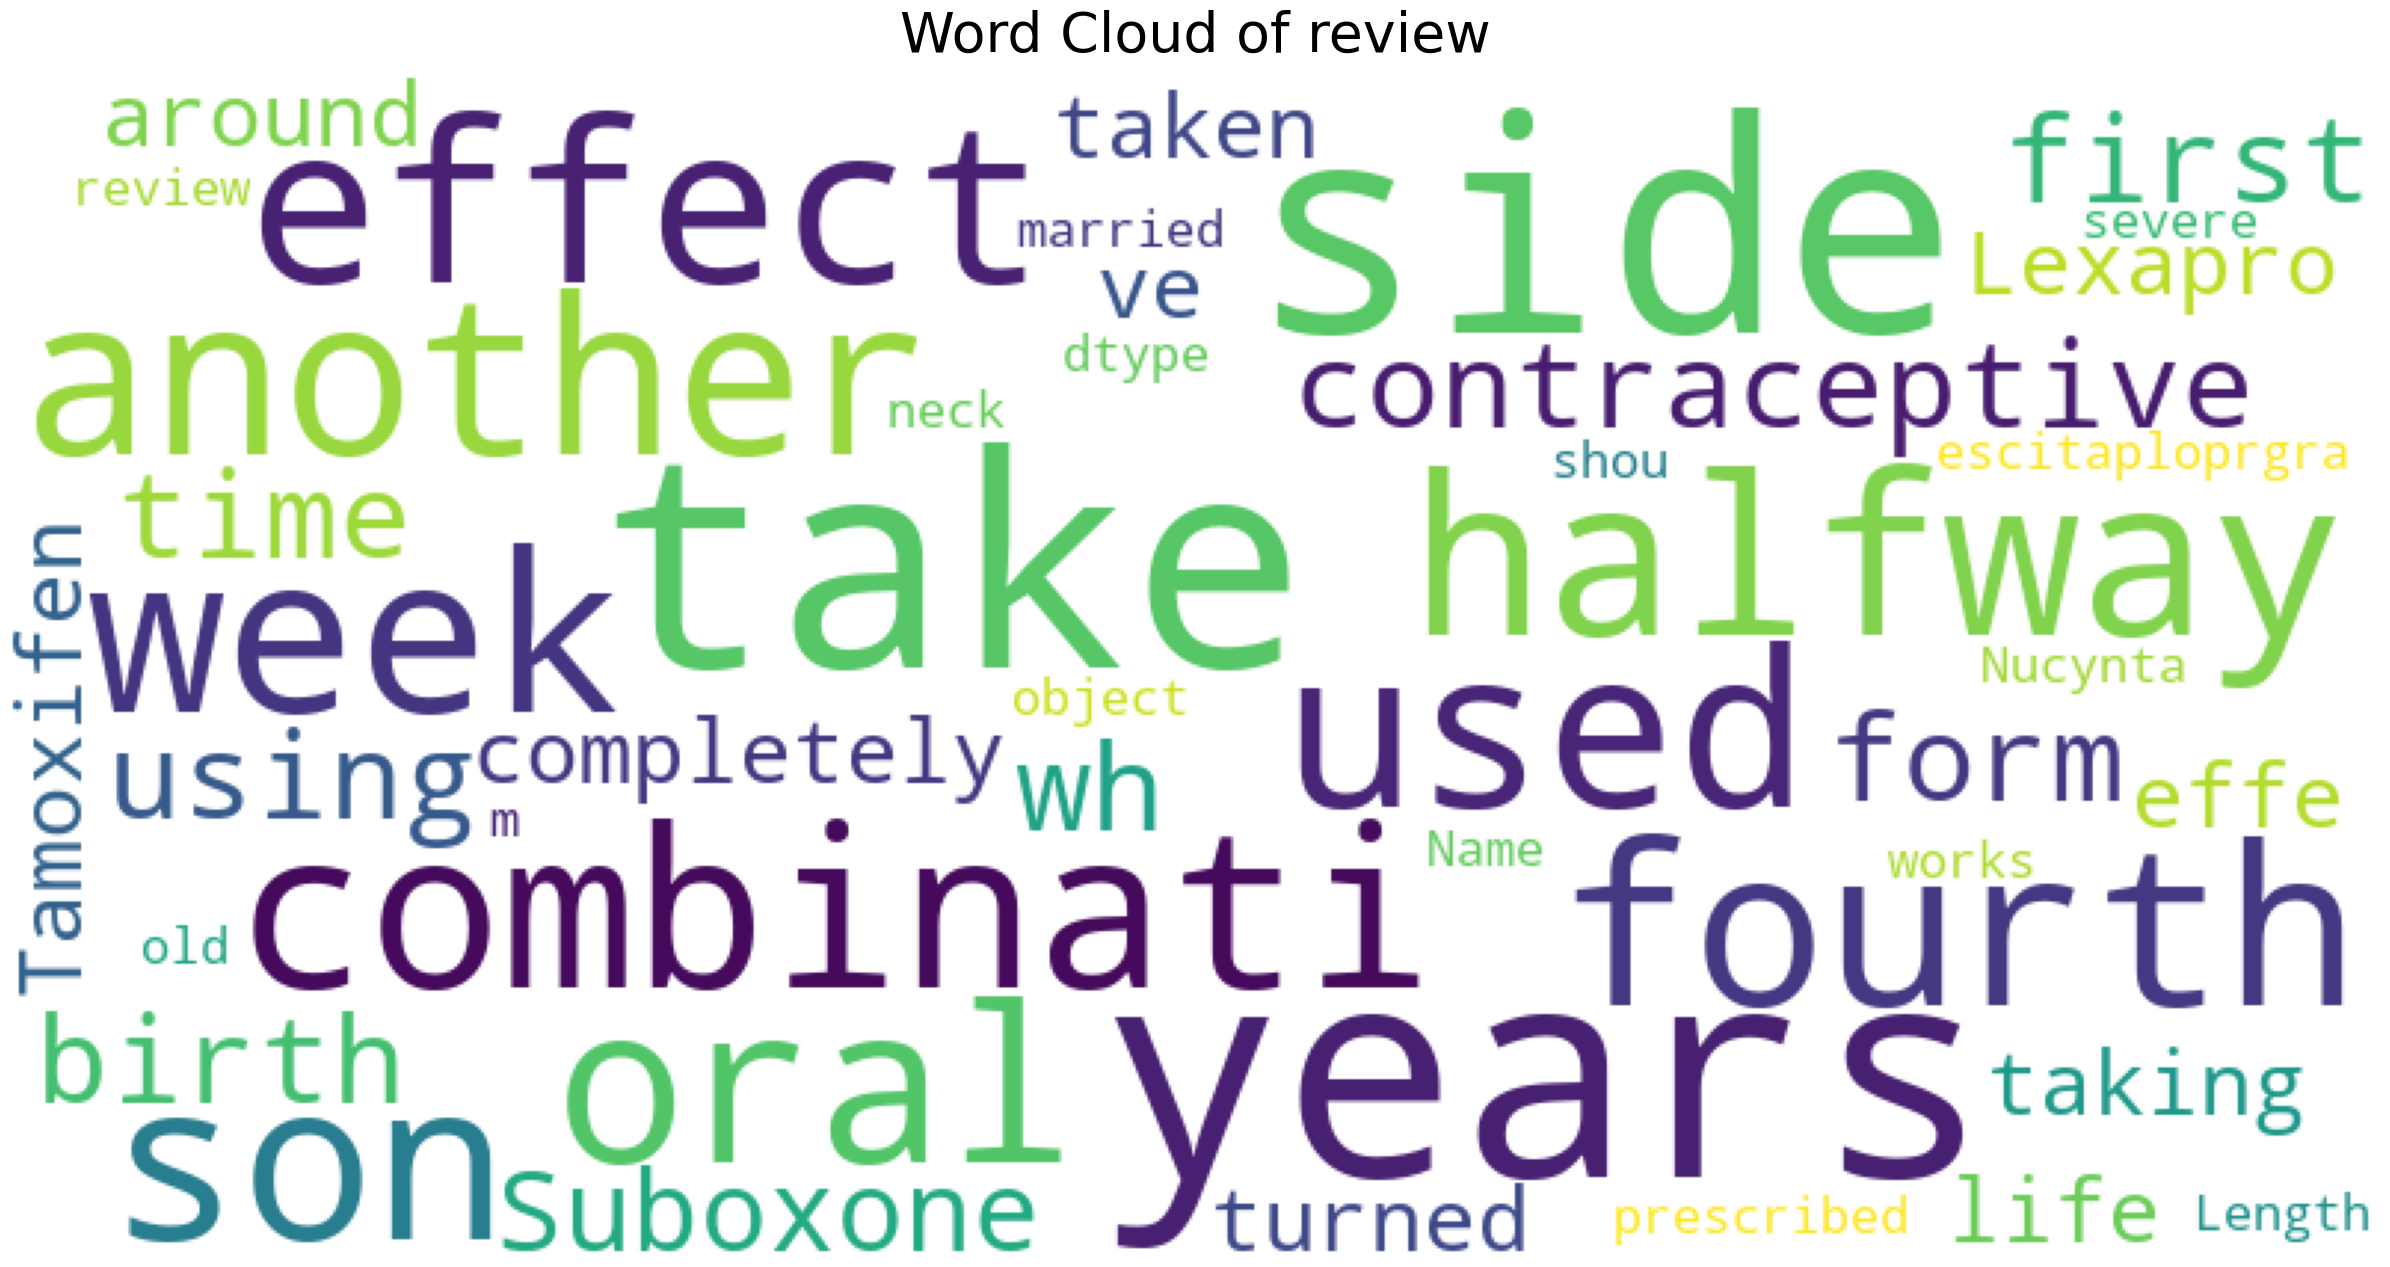

In [10]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df["review"], title="Word Cloud of review")

In [11]:
from collections import defaultdict
df_all_6_10 = df[df["rating"]>5]
df_all_1_5 = df[df["rating"]<6]

#### We classify ratings 1 ~ 5 as negative, and 6 ~ 10 as positive.

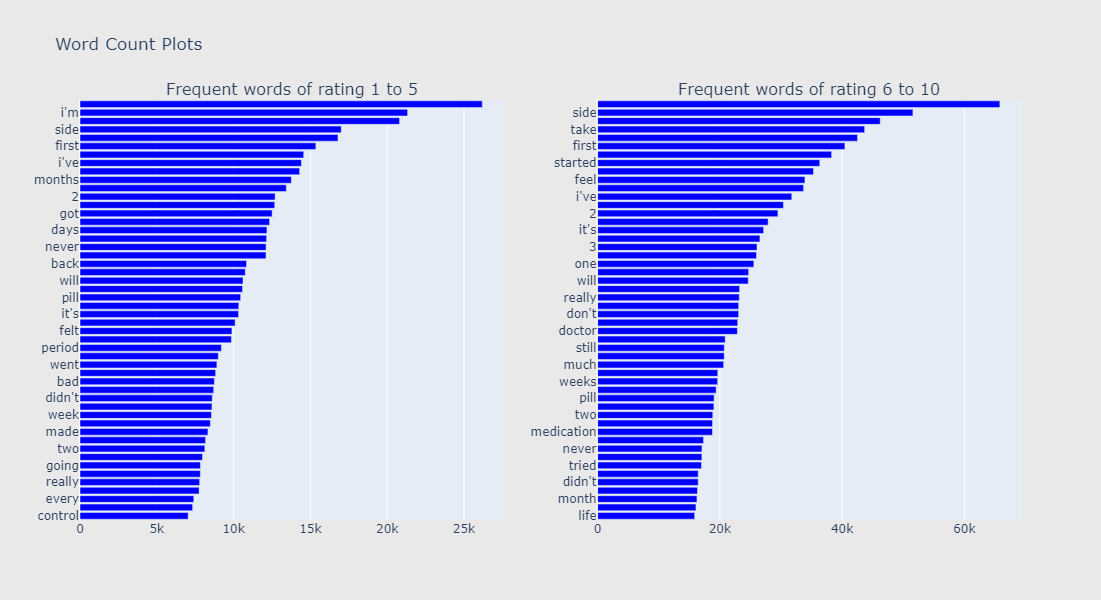

In [12]:
from plotly.subplots import make_subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace


freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')


freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of rating 1 to 5", 
                                          "Frequent words of rating 6 to 10"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig)

Text(0.5, 1.0, 'Count of rating values')

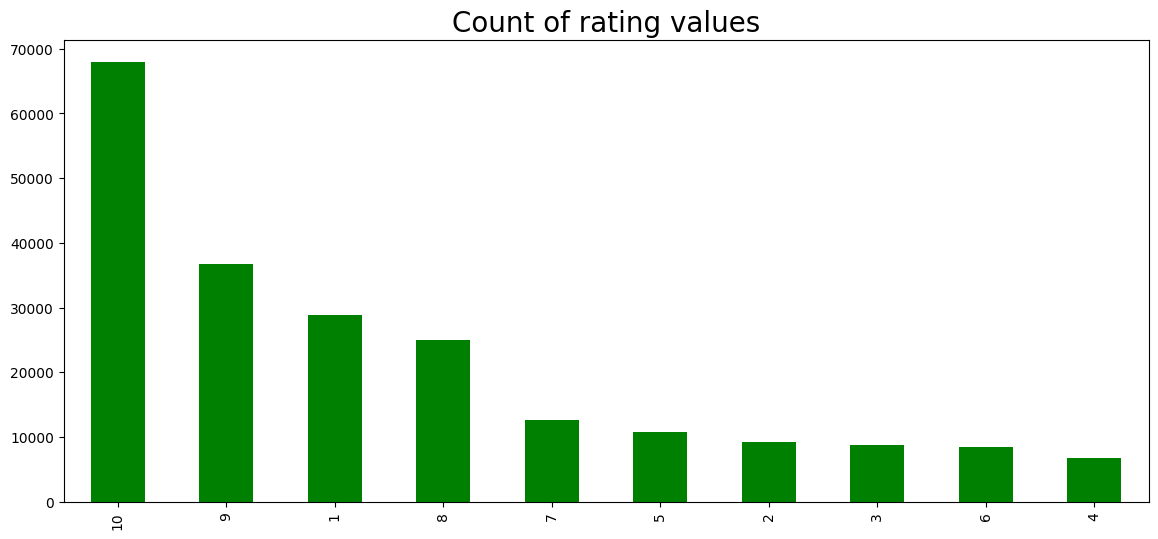

In [13]:
rating = df['rating'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Count of rating values", fontsize = 20)

In [14]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

C:\Users\yuvam\AppData\Local\Temp\ipykernel_205752\2370506791.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



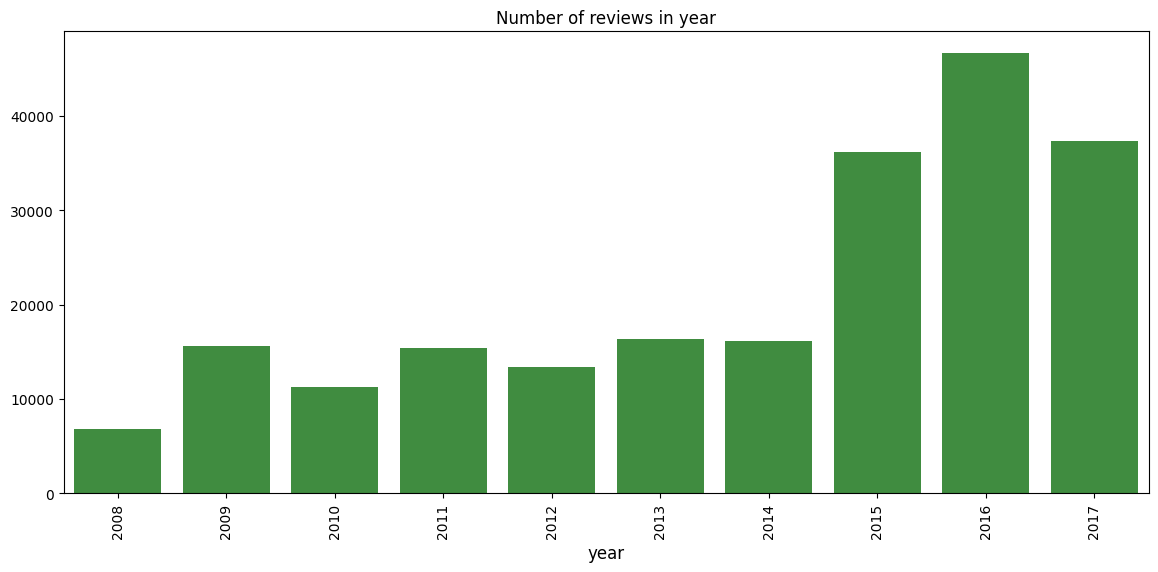

In [15]:
import seaborn as sns

cnt_srs = df['date'].dt.year.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('year', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Number of reviews in year")
plt.show()

Text(0.5, 1.0, 'Mean rating in year')

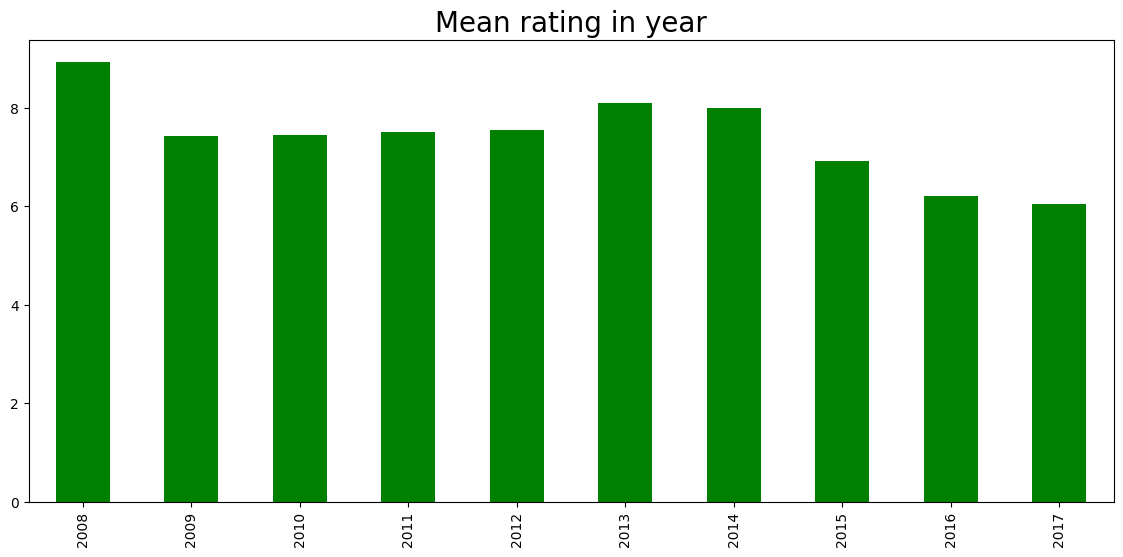

In [16]:
df['year'] = df['date'].dt.year
rating = df.groupby('year')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in year", fontsize = 20)

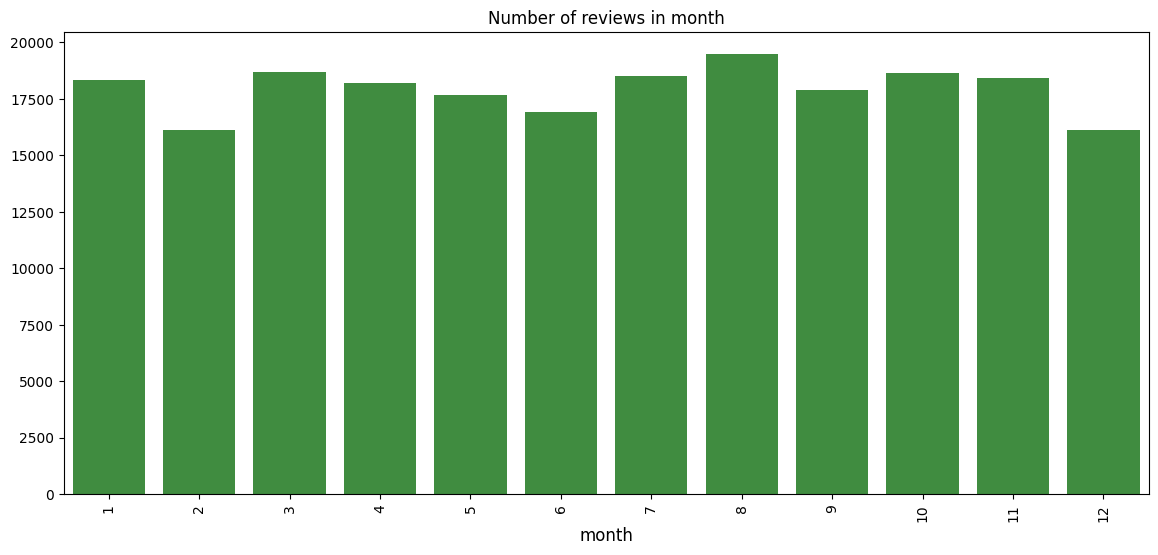

In [17]:
cnt_srs = df['date'].dt.month.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('month', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Number of reviews in month")
plt.show()

Text(0.5, 1.0, 'Mean rating in month')

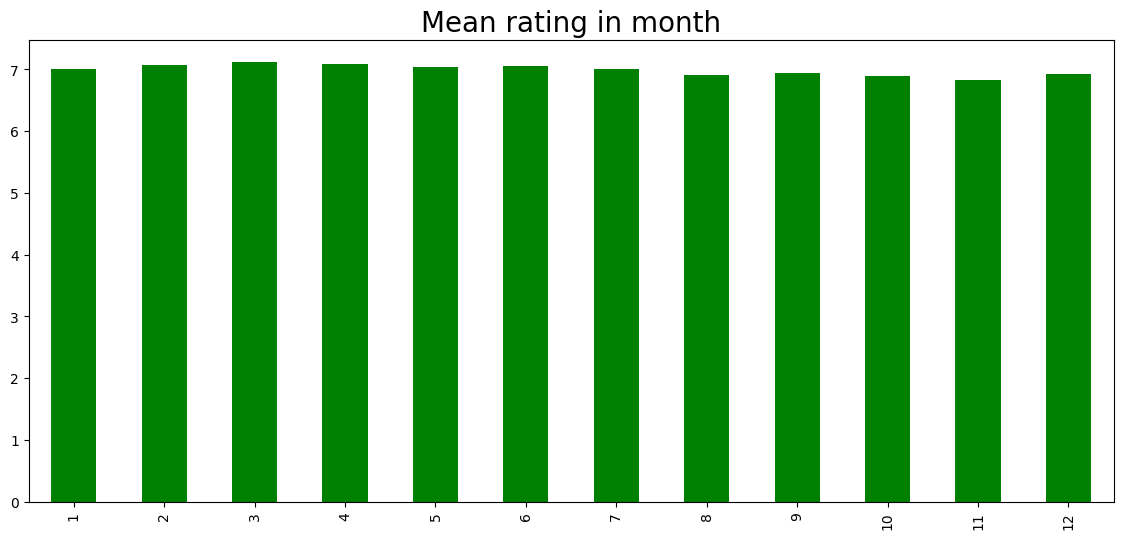

In [18]:
df['month'] = df['date'].dt.month
rating = df.groupby('month')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in month", fontsize = 20)

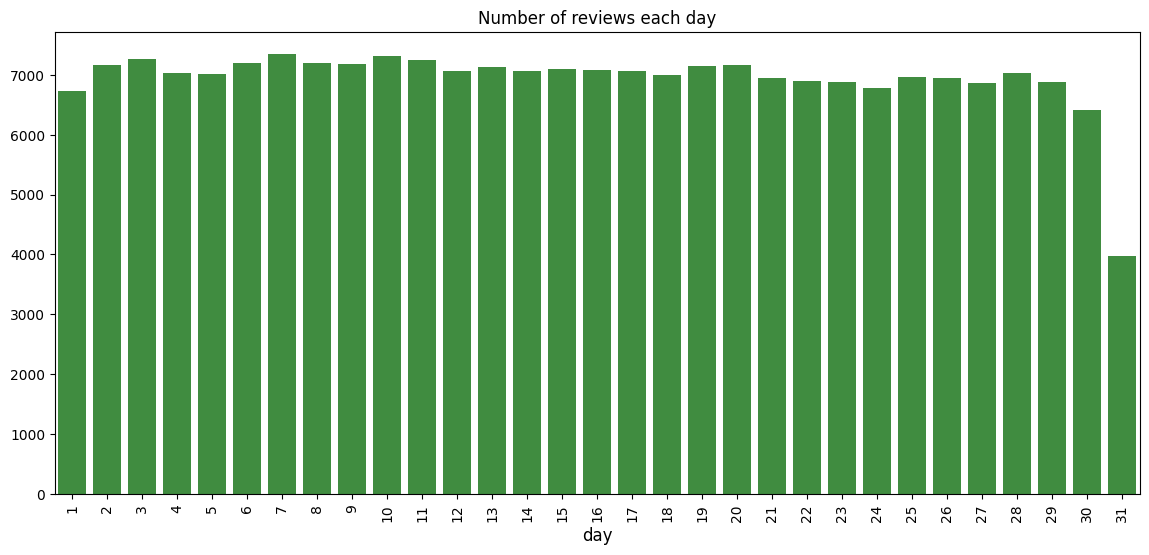

In [19]:
cnt_srs = df['date'].dt.day.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('day', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Number of reviews each day")
plt.show()

Text(0.5, 1.0, 'Mean rating in day')

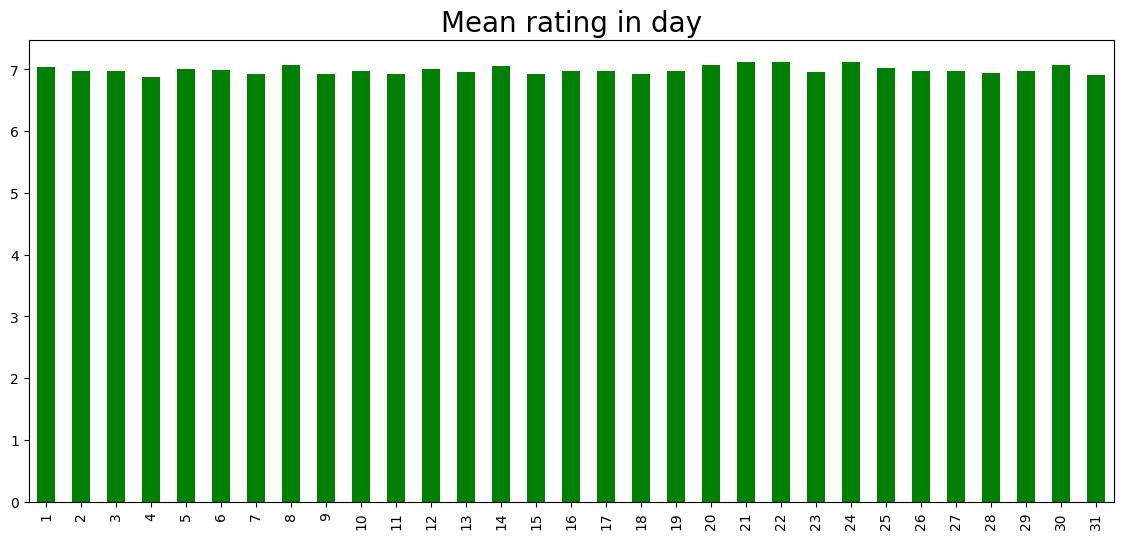

In [20]:
df['day'] = df['date'].dt.day
rating = df.groupby('day')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in day", fontsize = 20)

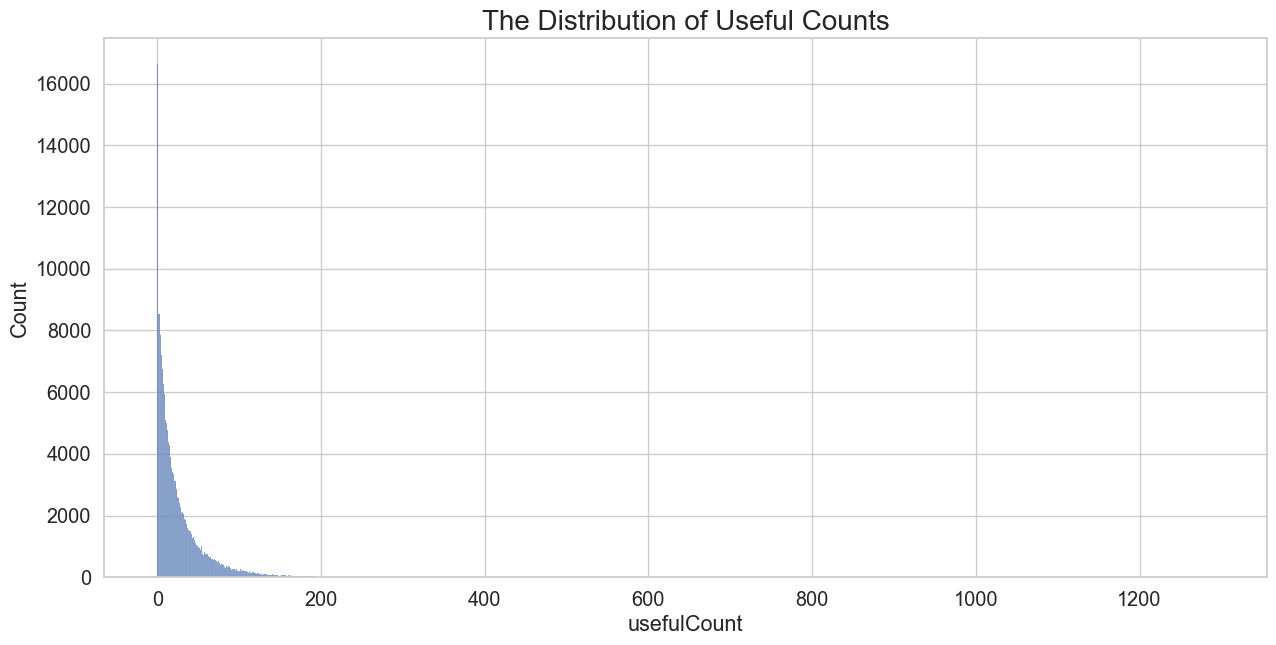

In [21]:
sns.set(style = 'whitegrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [15, 7]
sns.histplot(df['usefulCount'].dropna())
plt.title('The Distribution of Useful Counts', fontsize = 20)
plt.show()

#### Looking at the distribution of useful count, the difference between minimum and maximum is high. In addition, the deviation is huge. The reason for this is that the more drugs people look for, the more people read the review no matter their contents are good or bad, which makes the useful count very high. So when we create the model, we will normalize it by conditions, considering people's accessibility.

Text(0.5, 1.0, 'Total Missing Value ')

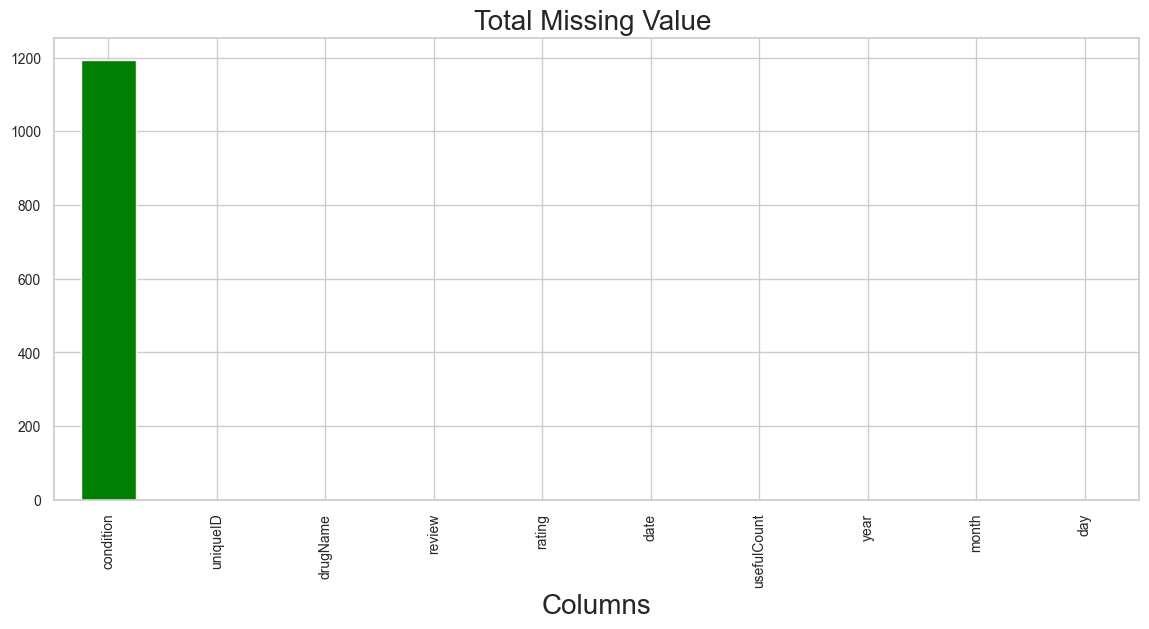

In [22]:
percent = (df.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

In [23]:
print("Missing value (%):", 1200/df.shape[0] *100)

Missing value (%): 0.5579760349292998


#### There are a few missing values as well in conditions. Looking at the percentage, which is less than 1, we will drop those instances.

C:\Users\yuvam\AppData\Local\Temp\ipykernel_205752\1128132068.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

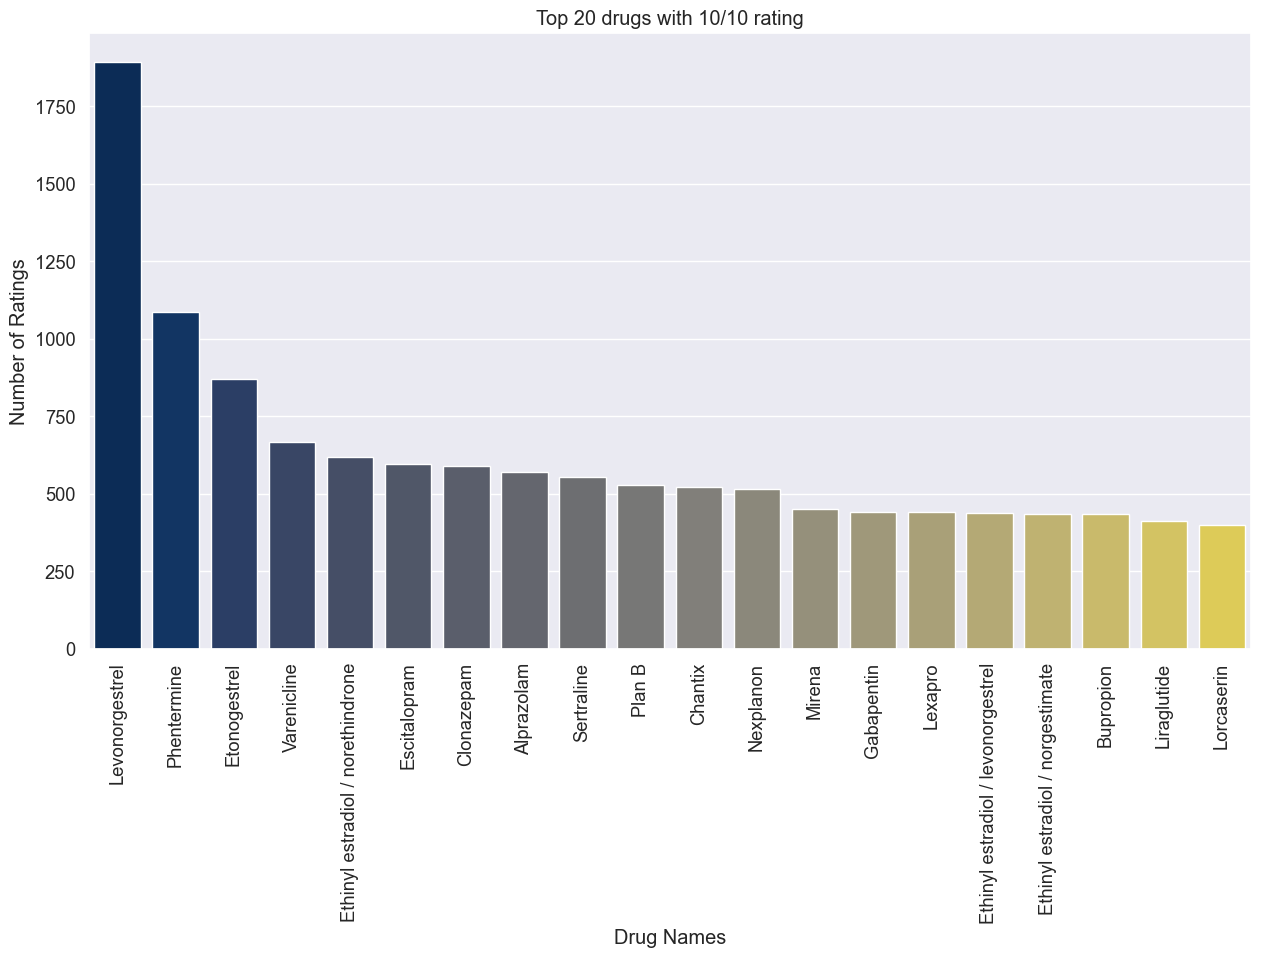

In [24]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df.loc[df.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'cividis')

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90)

C:\Users\yuvam\AppData\Local\Temp\ipykernel_205752\3218558712.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

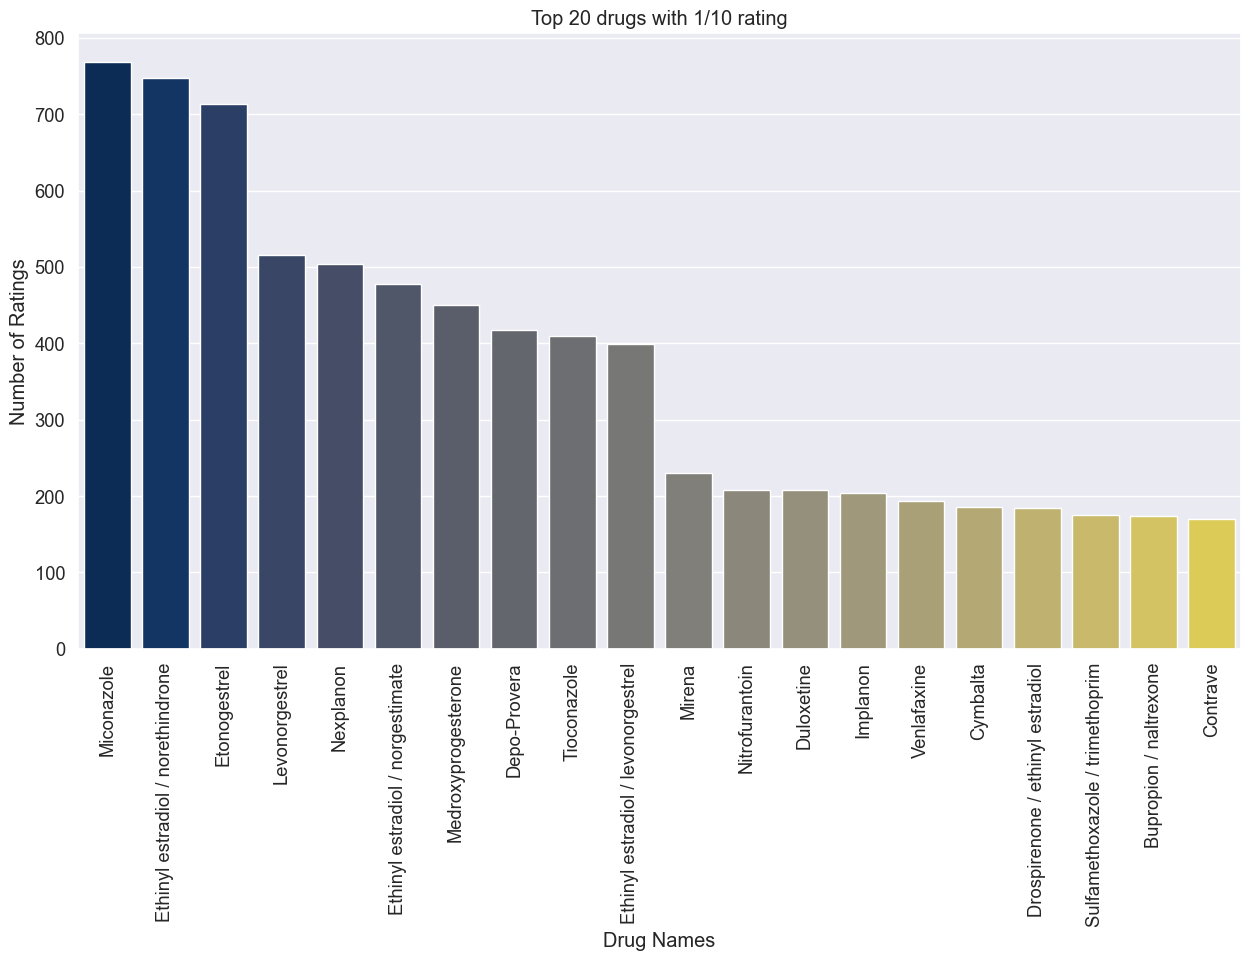

In [25]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df.loc[df.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'cividis')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90)